In [1]:
from tqdm import tqdm
from typing import List, Dict
import torch
from torch.utils.data import DataLoader
from seqeval.metrics import classification_report, precision_score, f1_score

from prepare_data import read_raw_data, preprocess_raw_data
from dataset import NERDataset
from model import CNN_BiRNN_CRF
from utils import set_random_seed, Config, load_json, make_padding, io2bio
from visualisation import plot_classification_report, highlight_entities

from IPython.display import HTML
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload
%autoreload 2

set_random_seed(seed=0)

In [2]:
config = Config('config.yaml')
config.__dict__

{'TR_PATH': 'data/supervised/train.txt',
 'VA_PATH': 'data/supervised/dev.txt',
 'TE_PATH': 'data/supervised/test.txt',
 'MAX_SEQ_LEN': 64,
 'MAX_WORD_LEN': 16,
 'WORD_SUPPORT': 10,
 'CHAR_SUPPORT': 100,
 'BATCH_SIZE': 128,
 'NUM_EPOCHS': 10,
 'LR': 0.001,
 'REG_LAMBDA': 0.0001,
 'MAX_GRAD_NORM': 100,
 'WORD_EMBED_SIZE': 128,
 'CHAR_EMBED_SIZE': 128,
 'KERNEL_SIZE': 3,
 'RNN_CELL': 'GRU',
 'RNN_HIDDEN_SIZE': 128,
 'NUM_LAYERS': 1,
 'DROPOUT': 0.5,
 'SKIP_CONNECTION': False}

In [3]:
te_titles = read_raw_data(filepath=config.TE_PATH)

In [4]:
te_titles

,id,words,tags_fine_grained,tags_coarse_grained
0,0,"[In, the, early, 1930s, the, band, moved, to, ...","[O, O, O, O, O, O, O, O, O, building-other, bu...","[O, O, O, O, O, O, O, O, O, building, building..."
1,1,"[The, final, season, of, minor, league, play, ...","[O, O, O, O, O, O, O, location-park, location-...","[O, O, O, O, O, O, O, location, location, loca..."
2,2,"[They, finished, the, season, 14–19, ,, 9–9, i...","[O, O, O, O, O, O, O, O, event-sportsevent, ev...","[O, O, O, O, O, O, O, O, event, event, O, O, O..."
3,3,"[The, B-52, pilot, ,, Major, Larry, G., Messin...","[O, product-other, O, O, O, person-other, pers...","[O, product, O, O, O, person, person, person, ..."
4,4,"[The, Austro-Hungarian, Navy, built, and, oper...","[O, organization-other, organization-other, O,...","[O, organization, organization, O, O, O, O, O,..."
...,...,...,...,...
37643,37643,"[The, remaining, 25, were, scrapped, in, 1959, .]","[O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O]"
37644,37644,"[Lady, Forester, died, in, 1922, .]","[O, person-other, O, O, O, O]","[O, person, O, O, O, O]"
37645,37645,"[As, all, aminopenicillins, ,, amoxicillin, ha...","[O, O, other-chemicalthing, O, other-chemicalt...","[O, O, other, O, other, O, O, O, O, other, oth..."
37646,37646,"[The, Storm, Prediction, Center, in, Oklahoma,...","[O, organization-other, organization-other, or...","[O, organization, organization, organization, ..."


# Prepare data

In [5]:
TAG2IDX = load_json('ner_tags/ner_fine_grained.json')
IDX2TAG = {i: t for t, i in TAG2IDX.items()}

WORD2IDX = load_json('tokenizers/word2idx.json')
IDX2WORD = {i: t for t, i in WORD2IDX.items()}

CHAR2IDX = load_json('tokenizers/char2idx.json')

In [6]:
# tag -> tagID
te_titles['tag_ids'] = te_titles['tags_fine_grained'].transform(lambda x: [TAG2IDX[tag] for tag in x])

# word -> wordID
te_titles['word_ids'] = te_titles['words'].transform(lambda x: [WORD2IDX[token] if token in WORD2IDX else WORD2IDX['UKN'] for token in x])

# padding
te_titles['word_ids'] = te_titles['word_ids'].transform(make_padding, max_len=config.MAX_SEQ_LEN)
te_titles['tag_ids'] = te_titles['tag_ids'].transform(make_padding, max_len=config.MAX_SEQ_LEN)

In [7]:
te_titles

,id,words,tags_fine_grained,tags_coarse_grained,tag_ids,word_ids
0,0,"[In, the, early, 1930s, the, band, moved, to, ...","[O, O, O, O, O, O, O, O, O, building-other, bu...","[O, O, O, O, O, O, O, O, O, building, building...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 12, 12, 1, 1, 10, ...","[25, 2, 166, 2825, 2, 277, 246, 8, 2, 7432, 39..."
1,1,"[The, final, season, of, minor, league, play, ...","[O, O, O, O, O, O, O, location-park, location-...","[O, O, O, O, O, O, O, location, location, loca...","[1, 1, 1, 1, 1, 1, 1, 27, 27, 27, 1, 1, 1, 1, ...","[12, 288, 81, 5, 1541, 567, 267, 1, 782, 175, ..."
2,2,"[They, finished, the, season, 14–19, ,, 9–9, i...","[O, O, O, O, O, O, O, O, event-sportsevent, ev...","[O, O, O, O, O, O, O, O, event, event, O, O, O...","[1, 1, 1, 1, 1, 1, 1, 1, 21, 21, 1, 1, 1, 1, 1...","[198, 528, 2, 81, 1, 3, 1, 7, 1, 267, 8, 2095,..."
3,3,"[The, B-52, pilot, ,, Major, Larry, G., Messin...","[O, product-other, O, O, O, person-other, pers...","[O, product, O, O, O, person, person, person, ...","[1, 63, 1, 1, 1, 55, 55, 55, 1, 1, 1, 1, 0, 0,...","[12, 15859, 1689, 3, 1122, 3247, 3210, 1, 3, 7..."
4,4,"[The, Austro-Hungarian, Navy, built, and, oper...","[O, organization-other, organization-other, O,...","[O, organization, organization, O, O, O, O, O,...","[1, 33, 33, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0...","[12, 15069, 675, 178, 6, 445, 50, 2480, 5, 359..."
...,...,...,...,...,...,...
37643,37643,"[The, remaining, 25, were, scrapped, in, 1959, .]","[O, O, O, O, O, O, O, O]","[O, O, O, O, O, O, O, O]","[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[12, 1448, 453, 30, 9933, 7, 1423, 4, 0, 0, 0,..."
37644,37644,"[Lady, Forester, died, in, 1922, .]","[O, person-other, O, O, O, O]","[O, person, O, O, O, O]","[1, 55, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[2162, 1, 278, 7, 2376, 4, 0, 0, 0, 0, 0, 0, 0..."
37645,37645,"[As, all, aminopenicillins, ,, amoxicillin, ha...","[O, O, other-chemicalthing, O, other-chemicalt...","[O, O, other, O, other, O, O, O, O, other, oth...","[1, 1, 42, 1, 42, 1, 1, 1, 1, 44, 44, 1, 44, 4...","[191, 95, 1, 3, 1, 38, 47, 818, 20, 1, 1635, 6..."
37646,37646,"[The, Storm, Prediction, Center, in, Oklahoma,...","[O, organization-other, organization-other, or...","[O, organization, organization, organization, ...","[1, 33, 33, 33, 1, 22, 1, 1, 1, 1, 1, 1, 1, 1,...","[12, 4050, 1, 222, 7, 2443, 40, 1282, 2, 4180,..."


# Data loader

In [8]:
te_dataset = NERDataset(data=te_titles, idx2word=IDX2WORD, char2idx=CHAR2IDX, max_word_len=config.MAX_WORD_LEN)
te_dataloader = DataLoader(dataset=te_dataset, batch_size=config.BATCH_SIZE, shuffle=False, num_workers=4)

te_dataset.__getitem__(123)

100%|██████████| 37648/37648 [00:08<00:00, 4374.44it/s]


{'word_ids': tensor([ 3474,    48,    96,   115,   158,     3,    29,  1209,     9,  3190,
             5,   557,     7, 17140,     6,  2211,    34,     8,     2,   324,
          1231,   313,     3,     1,     1,     3,    16,     2,   284,     5,
             9,  1597,     4,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0]),
 'char_ids': tensor([[28, 10,  7,  ...,  0,  0,  0],
         [ 3, 16,  4,  ...,  0,  0,  0],
         [48,  7,  8,  ...,  0,  0,  0],
         ...,
         [38, 29, 43,  ...,  0,  0,  0],
         [38, 29, 43,  ...,  0,  0,  0],
         [38, 29, 43,  ...,  0,  0,  0]]),
 'tag_ids': tensor([ 1,  1, 16, 16, 16,  1,  1,  1,  1,  1,  1,  1,  1, 22,  1,  1,  1,  1,
          1,  1,  1,  1,  1, 38, 38,  1,  1,  1,  1,  1,  1,  1,  1,  0,  0,  0,
          0,  0,  0,  0,  0,

In [9]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

model = CNN_BiRNN_CRF(
    word_embed_size  = config.WORD_EMBED_SIZE,
    char_embed_size  = config.CHAR_EMBED_SIZE,
    kernel_size      = config.KERNEL_SIZE,
    rnn_cell         = config.RNN_CELL,
    rnn_hidden_size  = config.RNN_HIDDEN_SIZE,
    dropout          = config.DROPOUT,
    num_layers       = config.NUM_LAYERS,
    skip_connection  = config.SKIP_CONNECTION,
    word_voc_size    = len(WORD2IDX),
    char_voc_size    = len(CHAR2IDX),
    tag_voc_size     = len(TAG2IDX),
).to(device)
print(model)

word_embedding.weight                    initialized w with Xavier            parameters #: 2530304
char_embedding.char_embedding.weight     initialized w with Xavier            parameters #: 15488
char_embedding.char_conv.weight          initialized w with Xavier            parameters #: 49152
char_embedding.char_conv.bias            initialized b with zero              parameters #: 128
rnn.weight_ih_l0                         initialized w with Xavier            parameters #: 49152
rnn.weight_hh_l0                         initialized w with Xavier            parameters #: 12288
rnn.weight_ih_l0_reverse                 initialized w with Xavier            parameters #: 49152
rnn.weight_hh_l0_reverse                 initialized w with Xavier            parameters #: 12288
fc.weight                                initialized w with Xavier            parameters #: 8704
fc.bias                                  initialized b with zero              parameters #: 68
crf.start_transitions   

In [10]:
state_dict = torch.load(f'weights/gru-2024-01-29 23-30-52/model_epoch_05.pt', map_location=torch.device(device))
model.load_state_dict(state_dict=state_dict)
model.eval()

CNN_BiRNN_CRF(
  (word_embedding): Embedding(19768, 128, padding_idx=0)
  (char_embedding): CharCNN(
    (char_embedding): Embedding(121, 128, padding_idx=0)
    (char_conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (rnn): GRU(256, 64, bias=False, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=68, bias=True)
  (crf): CRF(num_tags=68)
)

In [11]:
batch_trues = []
batch_preds = []

for te_batch in tqdm(te_dataloader, total=te_dataloader.__len__()):
    
    te_xs = te_batch['word_ids'].to(device)
    te_cs = te_batch['char_ids'].to(device)
    te_ys = te_batch['tag_ids'].to(device)
    te_mask = (te_ys > 0).bool()

    te_emission_scores = model(word_ids=te_xs, char_ids=te_cs).to(device)
    te_preds = torch.tensor(model.decode(te_emission_scores))
    
    for row_id, true in enumerate(te_ys):
        # do not count padding
        true_tags = true[te_mask[row_id]]
        # idx2tag
        true_tags = [IDX2TAG[idx] for idx in true_tags.tolist()]
        # convert to the format expected by seqeval
        true_tags = io2bio(true_tags)
        batch_trues.append(true_tags)

    for row_id, pred in enumerate(te_preds):
        # do not count padding
        pred_tags = pred[te_mask[row_id]]
        # idx2tag
        pred_tags = [IDX2TAG[idx] for idx in pred_tags.tolist()]
        # convert to the format expected by seqeval
        pred_tags = io2bio(pred_tags)
        batch_preds.append(pred_tags)

report = classification_report(y_true=batch_trues, y_pred=batch_preds, zero_division=0)
print(report)

  0%|          | 0/295 [00:00<?, ?it/s]

/Users/artemmerinov/PycharmProjects/NER/.venv/lib/python3.10/site-packages/torchcrf/__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 295/295 [01:51<00:00,  2.64it/s]


                                          precision    recall  f1-score   support

                    art-broadcastprogram       0.41      0.36      0.39       597
                                art-film       0.54      0.55      0.55       752
                               art-music       0.62      0.60      0.61      1028
                               art-other       0.24      0.13      0.16       562
                            art-painting       0.43      0.10      0.17        58
                          art-writtenart       0.45      0.46      0.46      1009
                        building-airport       0.87      0.76      0.81       363
                       building-hospital       0.74      0.67      0.70       362
                          building-hotel       0.70      0.62      0.66       263
                        building-library       0.70      0.61      0.65       355
                          building-other       0.50      0.42      0.46      2534
               

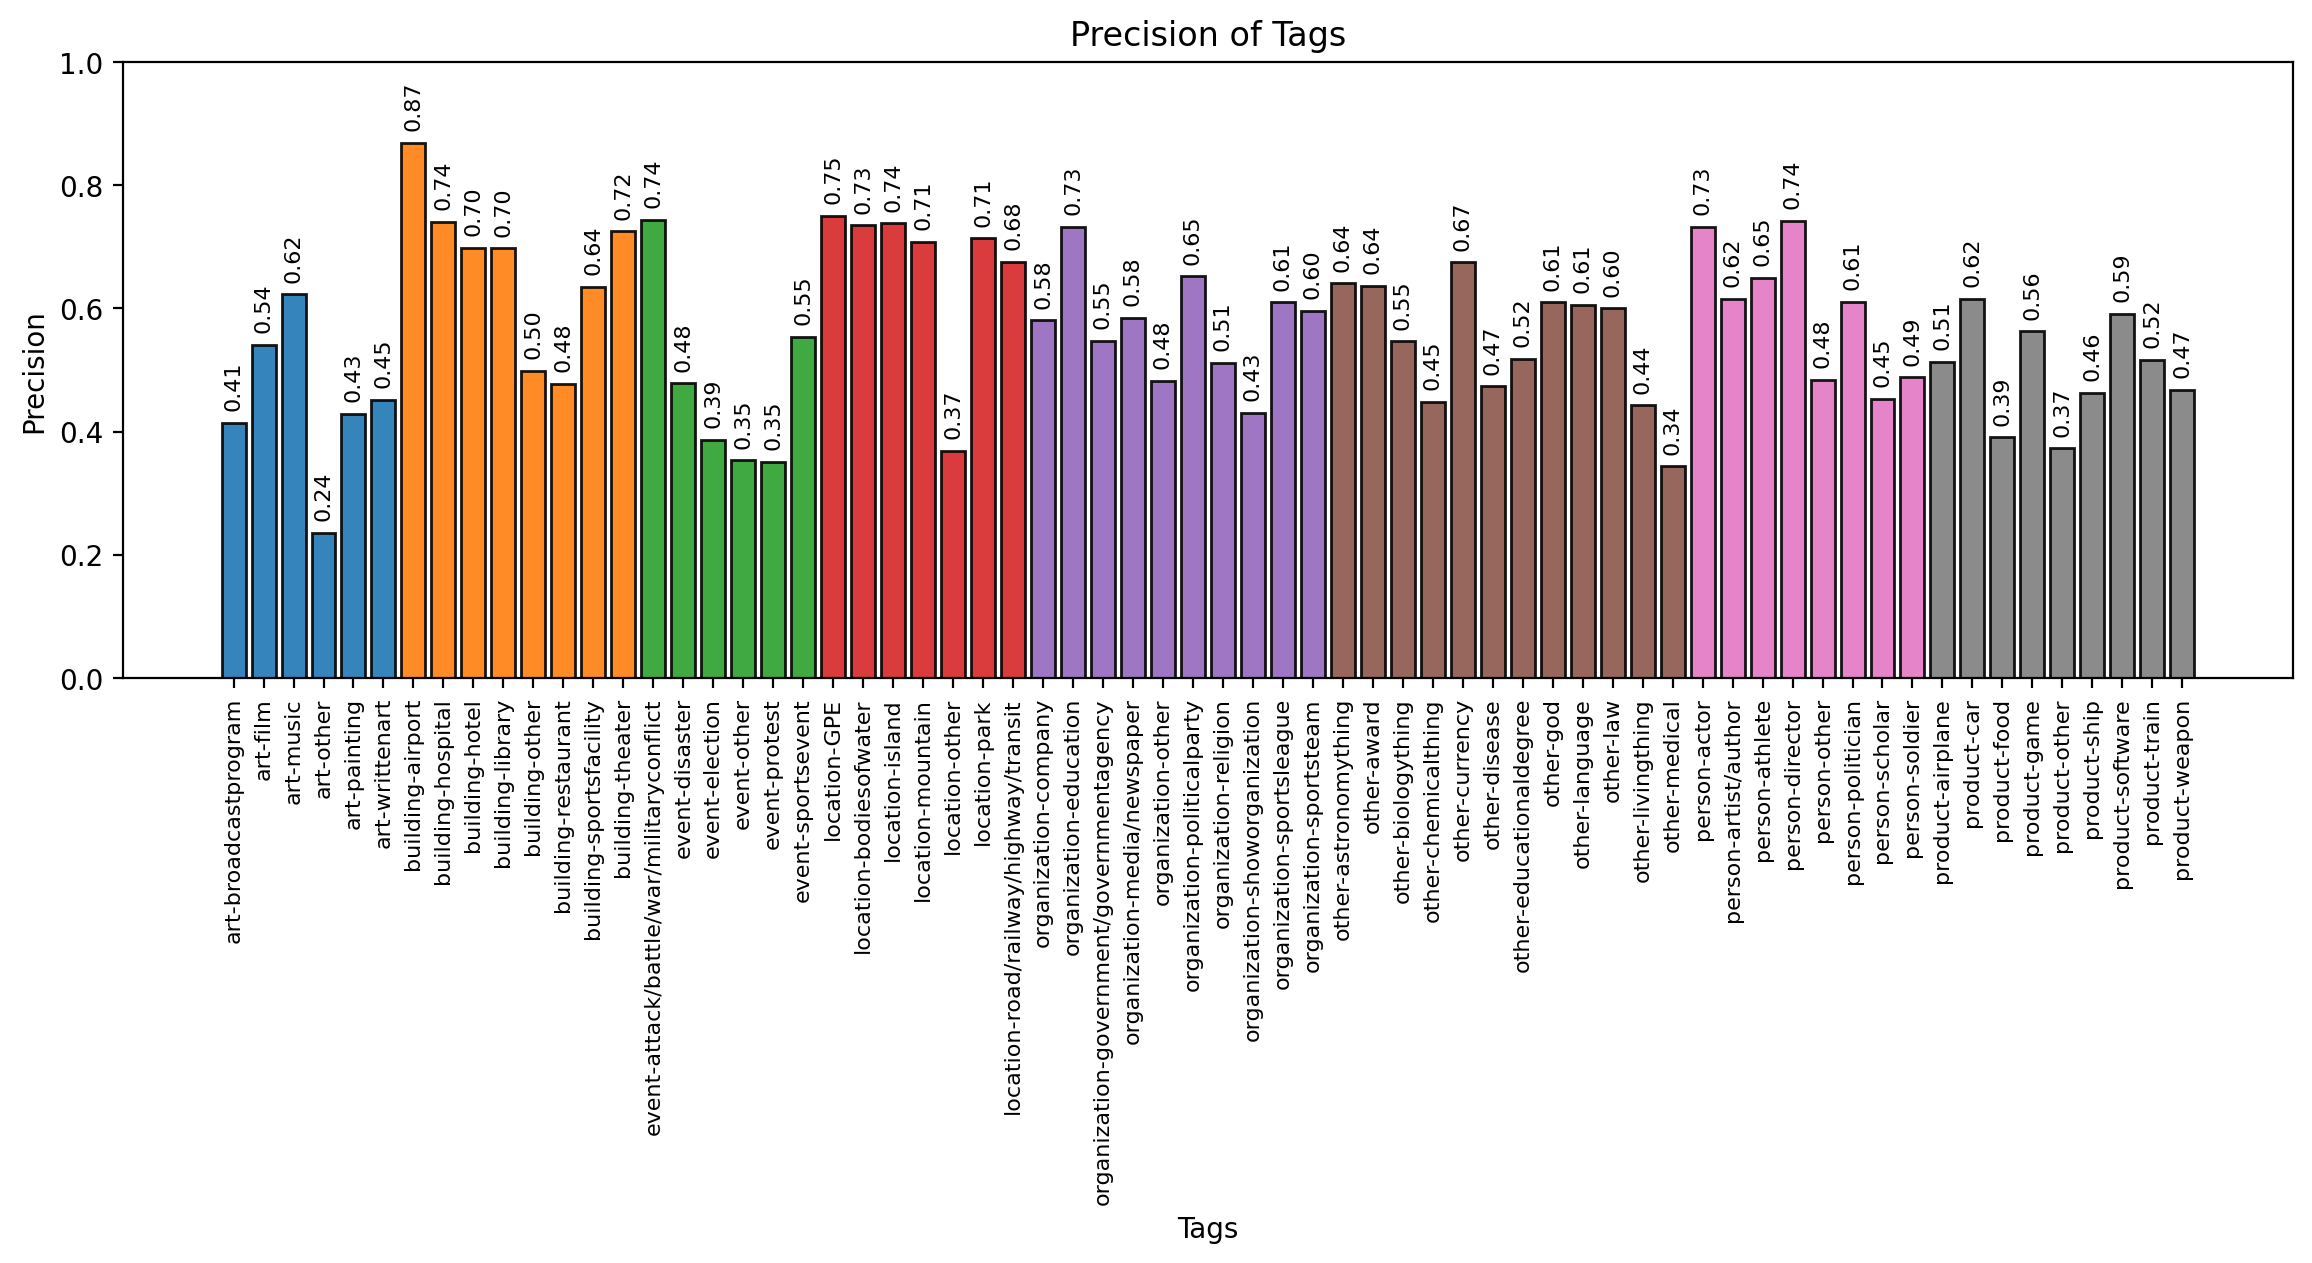

In [12]:
plot_classification_report(
    tag_names=list(TAG2IDX.keys())[2:],
    tag_scores=precision_score(y_true=batch_trues, y_pred=batch_preds, average=None)
)

# Demo

In [13]:
def predict_ner_for_sentence(
    sentence: str, 
    model: CNN_BiRNN_CRF = model,
    word2idx: Dict[str, int] = WORD2IDX,
    idx2word: Dict[int, str] = IDX2WORD,
    char2idx: Dict[str, int] = CHAR2IDX,
    max_seq_len: int = config.MAX_SEQ_LEN,
    max_word_len: int = config.MAX_WORD_LEN,
) -> List[str]:

    word_ids = [word2idx[token] if token in word2idx else word2idx['UKN'] for token in sentence.split(' ')]
    word_ids = make_padding(word_ids, max_len=max_seq_len)
    
    char_ids = []
    for word_id in word_ids:
        word = idx2word[word_id] if word_id in idx2word else 'UNK'
        char_seq = [char2idx[ch] if ch in char2idx else char2idx['UKN'] for ch in word]
        char_seq = make_padding(char_seq, max_len=max_word_len)
        char_ids.append(char_seq)

    word_ids = torch.tensor(word_ids)
    char_ids = torch.tensor(char_ids)
    mask = (word_ids > 0).bool()

    emission_scores = model(word_ids=word_ids.unsqueeze(0), char_ids=char_ids.unsqueeze(0))
    preds = torch.tensor(model.decode(emission_scores)).squeeze()
    preds = [IDX2TAG[idx] for idx in preds[mask].tolist()]
    preds = io2bio(preds)

    return preds

In [14]:
# let's generate some sentences using chatGPT
sentences = [
    "In the Louvre museum, visitors admired the exquisite paintings of Vincent van Gogh while discussing the impact of his work on modern art.",
    "During a protest organized by Greta Thunberg, environmental activists gathered in front of the United Nations headquarters to demand urgent action on climate change.",
    "At the Nobel Prize ceremony, the renowned physicist Stephen Hawking received recognition for his groundbreaking contributions to theoretical physics, and the event was attended by leaders from the European Organization for Nuclear Research (CERN) and influential figures from the global scientific community.",
    "The iconic Eiffel Tower in Paris attracts millions of visitors every year.",
    "Scientists at NASA recently discovered a new exoplanet in a distant galaxy, using advanced telescopes and data analysis techniques",
    "The FIFA World Cup captivated global audiences with thrilling soccer matches.",
    "The iconic Austin Maestro, a vintage product-car, drew enthusiasts with its timeless design and impressive performance.",
    "The European Under-19 Football Championship featured emerging talents like Luca Hernandez and Sophia Müller, showcasing the future of soccer.",
    "Mercedes-Benz introduced the luxurious C-Class, a product-car that blends elegance with cutting-edge automotive technology.",
    "The 2018 Winter Olympic Games witnessed the triumphs of athletes like Chloe Kim and Johannes Høsflot Klæbo, becoming household names.",
    "The Mars Rover, an ambitious NASA project, continues to explore the red planet, collecting valuable data about its geology and atmosphere.",
    "Anthony Smith, a renowned chef, introduced a new culinary masterpiece at his Michelin-starred restaurant, blending global flavors with local ingredients.",
    "The World Health Organization (WHO), a leading global health authority, plays a crucial role in addressing public health challenges worldwide.",
    "David, an avid space enthusiast, founded the Astronomy Club at his high school, organizing stargazing events and educational programs.",
    "The Great Barrier Reef, located off the coast of Australia, is a UNESCO World Heritage site and home to a diverse marine ecosystem.",
    "The Amazon Rainforest, a critical ecological region, is home to an incredible variety of plant and animal species.",
    "The Metropolitan Museum of Art in New York City, a world-renowned cultural institution, houses a vast collection of masterpieces spanning centuries.",
    "The Mona Lisa, painted by Leonardo da Vinci, is displayed in the Louvre Museum, a renowned cultural institution in Paris.",
    "The Hubble Space Telescope, a marvel of astronomy technology, captures breathtaking images of distant galaxies and nebulae.",
    "Sophie, a brilliant scholar, received her doctoral degree in Quantum Physics from Cambridge University, joining the ranks of esteemed scientists.",
    "The Golden Gate Bridge, an iconic landmark in San Francisco, spans the beautiful waters of the Bay Area.",
    "Mount Everest, the world's highest peak, attracts adventurers and climbers from all corners of the globe.",
    "The SpaceX Falcon 9 rocket, designed by Elon Musk's aerospace company, successfully launched a payload into orbit.",
    "The United Nations, an international organization for diplomacy and cooperation, addresses global challenges and conflicts.",
    "Mount Everest, the world's highest peak, poses a challenging ascent for climbers seeking the ultimate adventure.",
    "London is the fifth album by the British rock band Jesus Jones in 2001 through Koch Records",
    "Leonardo da Vinci painted The Mona Lisa, that is displayed in the Louvre Museum",
    "The iconic Eiffel Tower in Paris attracts millions of visitors.",
    "Barack Obama will travel to Hangzhou today for the G20 meeting.",
]   

for sentence in sentences:
    tokens = sentence.split(' ')
    ner_tags = predict_ner_for_sentence(sentence=sentence)
    highlighted_text = highlight_entities(tokens=tokens, ner_tags=ner_tags, font_size=14)
    # print(highlighted_text)
    display(HTML(highlighted_text))